In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Sourcing

In [6]:
from members import Members
member = Members().get_data()
member = Members().clean_data(member)

from weather import Weather
weather = Weather().get_data()
weather = Weather().clean_data(weather)

from expeds import Expeds
exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Dropping Columns

In [7]:
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation','summit_claimed',
               'summit_disputed','highpt','high_point','death','death_type','death_height',
               'death_class','summit_bid','summit_term','summit_date1','citizenship',
              'o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 'yob', 'route1', 'ascent1',
              'leader', 'deputy', 'bconly', 'nottobc', 'support', 'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders','sponsor','success1','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date','term_reason', 'summit_days',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')

# Merging

In [8]:
df = exped.merge(member, on='exp_id', how = 'right')

df = df.set_index('summit_date')
wet = weather.set_index('date_time')

df = df.merge(wet, how='left', left_index=True, right_index=True)

df = df.reset_index()
df.drop(columns=['exp_id', 'index', 'bc_date', 'moonrise', 'moonset', 'sunrise', 'sunset'], inplace = True)

# Data Correlation

In [10]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,primrte,peak_height,sex_M,disabled,summit_success,solo,traverse,ski,parapente,speed,o2_used,age,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
tot_days,1.000000,0.491003,0.142333,0.190612,0.313537,-0.146936,0.199105,0.529860,0.036943,0.599190,0.044874,0.003433,0.238522,-0.013423,-0.008598,-0.008792,-0.014043,-0.005664,0.520442,-0.093893,0.358925,0.439153,0.141007,0.248644,-0.306803,0.072934,0.472416,0.443643,0.444444,0.443643,-0.144631,0.310593,0.309646,0.208115,-0.471208,0.358925,-0.212333,-0.034885,-0.024457
camps,0.491003,1.000000,0.126914,0.106078,0.164017,-0.148227,0.156912,0.287563,-0.007707,0.287376,0.023582,-0.000842,0.264285,-0.008331,-0.005428,0.019034,0.005200,-0.002341,0.353290,-0.058889,0.277004,0.282331,0.059017,0.143391,-0.091048,0.036388,0.265404,0.308778,0.301244,0.308778,-0.102660,0.076368,0.075583,0.078202,-0.240969,0.277004,-0.022978,-0.148859,-0.067724
rope,0.142333,0.126914,1.000000,0.393814,0.307070,-0.084583,-0.093938,0.004049,0.029674,0.027613,0.011384,-0.014484,0.013501,-0.002293,-0.003036,-0.014495,-0.006033,-0.004536,0.042702,-0.014819,0.026008,0.046891,-0.052166,0.035657,0.029799,0.051059,0.045739,0.037896,0.042734,0.037896,-0.004709,0.009221,0.026508,-0.028590,-0.016099,0.026008,0.004172,-0.025104,0.004208
tot_members,0.190612,0.106078,0.393814,1.000000,0.694266,-0.202000,0.119914,0.093443,-0.019508,0.131114,-0.008849,-0.011464,0.060625,-0.016272,-0.006609,-0.029239,0.007083,-0.010196,0.134375,-0.030904,-0.059623,-0.054635,0.048944,-0.017971,-0.071144,0.033114,-0.000922,-0.012304,-0.038772,-0.012304,-0.085752,0.071806,0.064189,0.057927,-0.003136,-0.059623,-0.073050,-0.107944,-0.091781
tot_hired,0.313537,0.164017,0.307070,0.694266,1.000000,-0.269032,0.286553,0.309463,-0.015985,0.380923,0.040238,-0.005121,0.160785,-0.014848,-0.007264,-0.034729,0.002677,-0.010811,0.346474,-0.099005,0.004992,0.086219,0.121064,0.106863,-0.224062,-0.038030,0.141878,0.107037,0.076019,0.107037,-0.164487,0.214339,0.202570,0.114043,-0.151210,0.004992,-0.185355,-0.011475,-0.108988
no_hired,-0.146936,-0.148227,-0.084583,-0.202000,-0.269032,1.000000,-0.225447,-0.188830,0.027884,-0.203217,0.000930,0.008056,-0.121662,0.031804,0.001130,0.047663,-0.009687,0.026753,-0.243147,0.013909,-0.033252,-0.049417,-0.021583,-0.025731,0.080948,-0.033190,-0.067469,-0.065592,-0.051064,-0.065592,0.060417,-0.076814,-0.063728,-0.028312,0.069922,-0.033252,0.069397,0.015945,0.050289
comrte,0.199105,0.156912,-0.093938,0.119914,0.286553,-0.225447,1.000000,0.446762,-0.069262,0.402460,0.042113,0.009902,0.201505,-0.019219,-0.006764,-0.007119,0.005529,0.002764,0.297387,-0.091083,0.092389,0.159017,0.069168,0.030690,-0.214665,-0.068621,0.184266,0.168390,0.153123,0.168390,-0.136651,0.204720,0.174898,0.093697,-0.123507,0.092389,-0.152153,-0.069664,-0.087681
stdrte,0.529860,0.287563,0.004049,0.093443,0.309463,-0.188830,0.446762,1.000000,-0.015080,0.897621,0.051411,0.016285,0.114695,-0.021871,-0.011659,0.021180,0.001886,-0.004131,0.485852,-0.080638,0.360875,0.484392,0.242335,0.326634,-0.472530,0.066692,0.585906,0.531625,0.504639,0.531625,-0.337463,0.481086,0.483109,0.273994,-0.469740,0.360875,-0.347353,-0.103352,-0.143574
primrte,0.036943,-0.007707,0.029674,-0.019508,-0.015985,0.027884,-0.069262,-0.015080,1.000000,-0.015432,0.006969,-0.002754,-0.005353,-0.001297,-0.001005,-0.003511,-0.001230,-0.000820,-0.024463,-0.016539,-0.040674,-0.039195,0.031525,-0.019479,-0.010450,-0.025162,-0.017669,-0.021672,-0.033285,-0.021672,-0.039542,0.035282,0.023456,0.020186,0.017439,-0.040674,-0.046412,0.012155,-0.039335
peak_height,0.599190,0.287376,0.027613,0.131114,0.380923,-0.203217,0.402460,0.897621,-0.015432,1.000000,0.059520,0.012572,0.115538,-0.019505,-0.013420,0.002197,-0.001705,-0.002872,0.529483,-0.107604,0.314141,0.439012,0.251579,0.349351,-0.489200,0

# Data Preprocessing

In [11]:
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

In [13]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer


numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2)),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

# NN Model

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [16]:
def initialize_model():
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(203,)))
    model.add(layers.Dense(250, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(100, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

In [17]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30, restore_best_weights=True)

model = initialize_model()

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs= 300, 
                    batch_size=8,
                    verbose=0,
                   callbacks = [es])

Wall time: 1min 49s


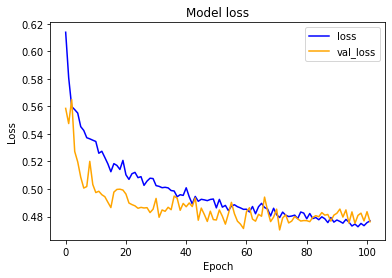

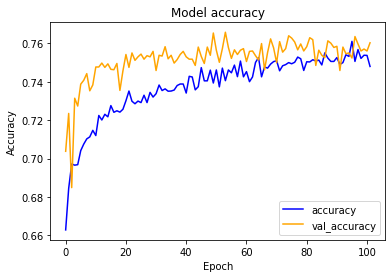

In [18]:
plt.plot(history.history['loss'], color = 'blue', label='loss')
plt.plot(history.history['val_loss'], color = 'orange', label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], color = 'blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
res = model.evaluate(X_test, y_test, verbose=0)
res[1]

0.76093590259552

In [21]:
from sklearn.metrics import classification_report
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.79      0.79      2837
        True       0.71      0.72      0.72      2078

    accuracy                           0.76      4915
   macro avg       0.76      0.76      0.76      4915
weighted avg       0.76      0.76      0.76      4915



## Learning Rate

In [ ]:
def optimizer_model(opt):
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(297,)))
    model.add(layers.Dense(300, activation = 'relu'))
    model.add(layers.Dense(100, activation = 'relu'))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = opt, 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

In [ ]:
%%time
from tensorflow.keras.optimizers import Adam

my_opt = Adam(learning_rate=0.01, name='Adam')


learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

hist = []

for lr in learning_rates:
    my_opt = Adam(learning_rate= lr)
    model = optimizer_model(my_opt)
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=200,
                        batch_size=16, 
                        verbose=0, 
                        callbacks=[es])
    hist.append(history.history)

In [ ]:
def plot_loss_mae_epoch(history, n_epochs):
    plt.plot(history['loss'][n_epochs:])
    plt.plot(history['val_loss'][n_epochs:])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history['accuracy'][n_epochs:])
    plt.plot(history['val_accuracy'][n_epochs:])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [ ]:
for lr,item in zip(learning_rates,hist):
    print(lr)
    plot_loss_mae_epoch(item, 0)

## Optimizer

In [ ]:
optimizers = ['Adadelta', 'Adagrad', 'Adamax', 'Adam', 'SGD']

hist = []

for my_opt in optimizers:
    model = optimizer_model(my_opt)
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=200,
                        batch_size=16, 
                        verbose=0, 
                        callbacks=[es])
    hist.append(history.history)

In [ ]:
for opt,item in zip(optimizers,hist):
    print(opt)
    plot_loss_mae_epoch(item, 0)

## Batch Size

In [ ]:
batches = [2,4,8,16]

batch = []

for bat in batches:
    model = initialize_model()
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=200,
                        batch_size= bat, 
                        verbose=0, 
                        callbacks=[es])
    batch.append(history.history)

In [ ]:
for bat,item in zip(batches, batch):
    print(bat)
    plot_loss_mae_epoch(item, 0)

# NN vs Xgb

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.79      0.79      2837
        True       0.71      0.72      0.72      2078

    accuracy                           0.76      4915
   macro avg       0.76      0.76      0.76      4915
weighted avg       0.76      0.76      0.76      4915



In [28]:
from xgboost import XGBClassifier

boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.82      0.84      2837
        True       0.77      0.81      0.79      2078

    accuracy                           0.82      4915
   macro avg       0.81      0.81      0.81      4915
weighted avg       0.82      0.82      0.82      4915

